# Fully discretized, scale factor parameterization

In [13]:
import par
import bg_test as bg
import numops
from copy import deepcopy as cp
from scipy import integrate
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import pickle
import numba
plt.rcParams.update(par.plot_params)

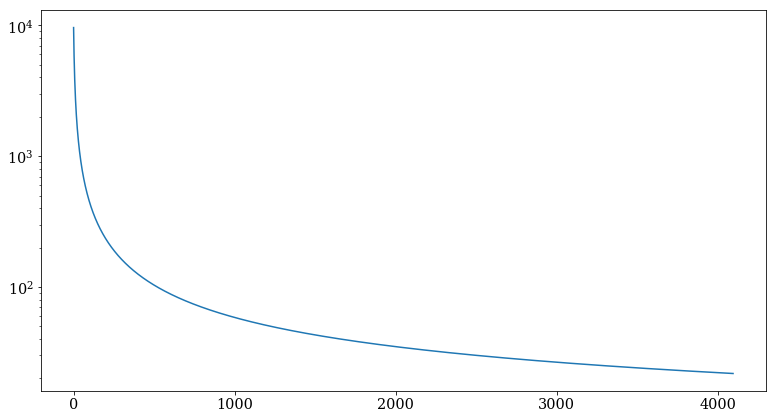

In [14]:
# set the A and k arrays.
A = np.linspace(par.a0, par.a_rec, par.N_T_SOLVE)
k_solve= np.geomspace(par.k_low, par.k_high, par.N_K_SOLVE)

# globally accessible background quantities
OmegaB0 = par.MLparams['OmegaB0']
OmegaC0 = par.MLparams['OmegaC0']
OmegaG0 = par.MLparams['OmegaG0']
OmegaN0 = par.MLparams['OmegaN0']
OmegaL = par.MLparams['OmegaL']
OmegaD = np.zeros(par.N_T_SOLVE)
wD = par.MLparams['wD']
DwD = np.gradient(wD)
cs2D = par.MLparams['cs2D']
TAU = bg.get_TAU(A, par.MLparams)
H = bg.get_H(A, par.MLparams)
plt.semilogy(H)


In [15]:
"""3 fluid"""
def DY_3fld_fix(i, Y):
    dY = np.zeros((7, par.N_K_SOLVE))
    Phi = Y[0, :]
    deltaG = Y[1, :]
    vG = Y[2, :]
    deltac = Y[3, :]
    vC = Y[4, :]
    deltaN = Y[5, :]
    vN = Y[6, :]

    # compute background quantities for the current
    # time step.
    Hi = H[i]
    H0 = par.H0
    ai = A[i]
    ybi = 1.68*ai*par.OmegaB0/par.OmegaR0
    OmegaBi = par.OmegaB0 * ai**-3.
    OmegaCi = par.OmegaC0 * ai**-3.
    OmegaGi = par.OmegaG0 * ai**-4.
    OmegaNi = par.OmegaN0 * ai**-4
    

    # compute the derivatives of the perturbations.
    DPhi = -Hi*Phi + (3/2.*H0**2.*ai**2/k_solve) *\
        (4./3.*(OmegaGi*vG + OmegaNi*vN) + OmegaCi*vC + OmegaBi*vG)

    DdeltaG = -4./3.*k_solve*vG + 4*DPhi
    DvG = (-Hi * ybi*vG + k_solve*deltaG/3)/(
        4./3. + ybi) + k_solve*Phi

    Ddeltac = -k_solve*vC + 3*DPhi
    DvC = -Hi*vC + k_solve*Phi

    DdeltaN = -4./3.*k_solve*vN + 4*DPhi
    DvN = k_solve*deltaN/4 + k_solve*Phi

    DdeltaN = -4./3.*k_solve*vN + 4*DPhi
    DvN = k_solve*deltaN/4. + k_solve*Phi

    dY[0, :] = DPhi
    dY[1, :] = DdeltaG
    dY[2, :] = DvG
    dY[3, :] = Ddeltac
    dY[4, :] = DvC
    dY[5, :] = DdeltaN
    dY[6, :] = DvN

    return dY



In [16]:
def solve_3fld_fix(params):
     
    H = bg.get_H(A, params)
    TAU = bg.get_TAU(A, params)
    
    # set initial conditions
    y0 = params['a0']/params['a_eq']
    Phi0 = np.ones(par.N_K_SOLVE)
    deltaG0 = -2*Phi0*(1 + 3*y0/16)
    vG0 = -k_solve/(H[0]) * (deltaG0/4 + (2*k_solve**2 * (1 + y0)*Phi0) /
                              (9*(H[0])**2 * (4./3. + y0)))
    deltaC0 = .75 * deltaG0
    vC0 = vG0
    deltaN0 = deltaG0
    vN0 = vG0

    Y = np.zeros((len(TAU)//2, 7, par.N_K_SOLVE))
    Y[0, :, :] = np.array([Phi0, deltaG0, vG0, deltaC0, vC0, deltaN0, vN0])
    # RK4 implementation
    for i in range(par.N_T_SOLVE//2-1):
        ss = TAU[2*i+2] - TAU[2*i]
        k1 = ss*DY_3fld_fix(2*i, Y[i, :, :])
        k2 = ss*DY_3fld_fix(2*i+1, Y[i, :, :]+k1/2)
        k3 = ss*DY_3fld_fix(2*i+1, Y[i, :, :]+k2/2)
        k4 = ss*DY_3fld_fix(2*i+2, Y[i, :, :]+k3)

        Y[i+1, :, :] = Y[i, :, :] + k1/6 + k2/3 + k3/3 + k4/6
    return Y

   


In [17]:
"""3 fluid"""
def DY(i, Y):
    dY = np.zeros((9, par.N_K_SOLVE))
    Phi = Y[0, :]
    deltaG = Y[1, :]
    vG = Y[2, :]
    deltac = Y[3, :]
    vC = Y[4, :]
    deltaN = Y[5, :]
    vN = Y[6, :]
    deltaD= Y[7, :]
    vD = Y[8, :]

    # compute background quantities for the current
    # time step.
    wDi = wD[i]
    DwDi = DwD[i]
    cs2Di = cs2D[i,:]
    Hi = H[i]
    H0 = par.H0
    ai = A[i]
    ybi = 1.68*ai*par.OmegaB0/par.OmegaR0
    OmegaBi = OmegaB0 * ai**-3.
    OmegaCi = OmegaC0 * ai**-3.
    OmegaGi = OmegaG0 * ai**-4.
    OmegaNi = OmegaN0 * ai**-4
    OmegaDi = OmegaD[i]

    # compute the derivatives of the perturbations.
    DPhi = -Hi*Phi + (3/2.*H0**2.*ai**2/k_solve) *\
        (4./3.*(OmegaGi*vG + OmegaNi*vN) + OmegaCi*vC + OmegaBi*vG +
         (1+wDi)*OmegaDi*vD)
    
    DdeltaG = -4./3.*k_solve*vG + 4*DPhi
    DvG = (-Hi * ybi*vG + k_solve*deltaG/3)/(
        4./3. + ybi) + k_solve*Phi

    Ddeltac = -k_solve*vC + 3*DPhi
    DvC = -Hi*vC + k_solve*Phi

    DdeltaN = -4./3.*k_solve*vN + 4*DPhi
    DvN = k_solve*deltaN/4 + k_solve*Phi
    
    #print(len(k_solve), len(vD), len(DPhi))
    DdeltaD = -(1+wDi)*(k_solve*vD-3*DPhi) - 3*Hi*(cs2Di-wDi)*deltaD
    DvD = -Hi*(1-3*wDi)*vD - vD*DwDi/(1+wDi) + k_solve*deltaD*cs2Di/(1+wDi) + k_solve*Phi

    dY[0, :] = DPhi
    dY[1, :] = DdeltaG
    dY[2, :] = DvG
    dY[3, :] = Ddeltac
    dY[4, :] = DvC
    dY[5, :] = DdeltaN
    dY[6, :] = DvN
    dY[7, :] = DdeltaD
    dY[8, :] = DvD

    return dY

def solve(params):
    global OmegaB0, OmegaC0, OmegaG0, OmegaN0, OmegaL, OmegaD, wD, DwD, cs2D, TAU, H
    # globally accessible background quantities
    OmegaB0 = params['OmegaB0']
    OmegaC0 = params['OmegaC0']
    OmegaG0 = params['OmegaG0']
    OmegaN0 = params['OmegaN0']
    OmegaL = params['OmegaL']
    OmegaD = bg.get_OmegaD(A, params)
    wD = params['wD']
    DwD = np.gradient(wD)
    cs2D = params['cs2D']
    TAU = bg.get_TAU(A, par.MLparams)
    H = bg.get_H(A, par.MLparams)
    
    # set initial conditions
    y0 = params['a0']/params['a_eq']
    Phi0 = np.ones(par.N_K_SOLVE)
    deltaG0 = -2*Phi0*(1 + 3*y0/16)
    vG0 = -k_solve/(H[0]) * (deltaG0/4 + (2*k_solve**2 * (1 + y0)*Phi0) /
                              (9*(H[0])**2 * (4./3. + y0)))
    deltaC0 = .75 * deltaG0
    vC0 = vG0
    deltaN0 = deltaG0
    vN0 = vG0
    deltaD0 = params['deltaD0']
    vD0 = params['vD0']

    Y = np.zeros((len(TAU)//2, 9, par.N_K_SOLVE))
    Y[0, :, :] = np.array([Phi0, deltaG0, vG0, deltaC0, vC0, deltaN0, vN0, deltaD0, vD0])
    # RK4 implementation
    for i in range(par.N_T_SOLVE//2-1):
        ss = TAU[2*i+2] - TAU[2*i]
        k1 = ss*DY(2*i, Y[i, :, :])
        k2 = ss*DY(2*i+1, Y[i, :, :]+k1/2)
        k3 = ss*DY(2*i+1, Y[i, :, :]+k2/2)
        k4 = ss*DY(2*i+2, Y[i, :, :]+k3)

        Y[i+1, :, :] = Y[i, :, :] + k1/6 + k2/3 + k3/3 + k4/6
    return Y


In [18]:
#Y = solve_3fld_fix(par.MLparams)
TAU_out = TAU[::2]
Y = solve(par.MLparams)
Phi = Y[:, 0, :].T
deltaG = Y[:, 1, :].T
vG = Y[:, 2, :].T
deltaC = np.array([np.interp(TAU, TAU_out, Y[:, 3, j].T) for j in range(256)])
vC = np.array([np.interp(TAU, TAU_out, Y[:, 4, j].T) for j in range(256)])
deltaN = np.array([np.interp(TAU, TAU_out, Y[:, 5, j].T) for j in range(256)])
vN = np.array([np.interp(TAU, TAU_out, Y[:, 6, j].T) for j in range(256)])



OmegaB = par.OmegaB0 * A**-3
OmegaC = par.OmegaC0 * A**-3
OmegaN = par.OmegaN0 * A**-4
OmegaG = par.OmegaG0 * A**-4
OmegaD = OmegaN + OmegaC

wD = OmegaN/(3*OmegaD)
deltaD = (OmegaC*deltaC + OmegaN*deltaN)/OmegaD
vD = (OmegaC*vC + 4/3*OmegaN*vN)/((1+wD)*OmegaD)
cs2D = (deltaN*OmegaN*1/3)/(deltaD*OmegaD)

par_2f = cp(par.MLparams)
par_2f['wD'] = OmegaN/(3*OmegaD)
par_2f['cs2D'] = cs2D
par_2f['OmegaD_tau0'] = par.OmegaN0 + par.OmegaG0
par_2f['deltaD0'] = deltaD[:,0]
par_2f['vD0'] = vD[:,0]
#print(np.shape(par_2f['deltaD0']))
par_2f['OmegaC0'] = 0
par_2f['OmegaN0'] = 0

Y2f = solve(par_2f)

ValueError: operands could not be broadcast together with shapes (4096,) (256,) 

In [ ]:
"""Extract GDM functions

OmegaB = par.OmegaB0 * A[::2]**-3
OmegaC = par.OmegaC0 * A[::2]**-3
OmegaN = par.OmegaN0 * A[::2]**-4
OmegaG = par.OmegaG0 * A[::2]**-4

OmegaD = OmegaN + OmegaC

wd = OmegaN/(3*OmegaD)
deltaD = (OmegaC*deltaC + OmegaN*deltaN)/OmegaD
vD = (OmegaC*vC + 4/3*OmegaN*vN)/((1+wd)*OmegaD)
cs2d = (deltaN*OmegaN*1/3)/(deltaD*OmegaD)
"""

In [ ]:
# plot some outputs for sanity check
plt.plot(TAU_out, deltaD.T[:, 0::25])
plt.show()
plt.plot(TAU_out, Phi.T[:, 0::25])
plt.show()